# Freesolv

In the interest of diagnosing problems in making MM --> ANI corrections, I will first focus effort on assessing the improvement of hydration free energy calculations from the Freesolv Dataset

In [1]:
import os
import numpy as np
import pickle

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 24
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title"

default_color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
freesolv_data_str = os.path.join(os.getcwd(), 'database.txt')
with open(freesolv_data_str, 'r') as f:
    freesolv_data = f.read().splitlines()

In [4]:
freesolv_data_template = freesolv_data[2].split(';')
print([(idx, k) for idx, k in enumerate(freesolv_data_template)])

[(0, '# compound id (and file prefix)'), (1, ' SMILES'), (2, ' iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)'), (3, ' experimental value (kcal/mol)'), (4, ' experimental uncertainty (kcal/mol)'), (5, ' Mobley group calculated value (GAFF) (kcal/mol)'), (6, ' calculated uncertainty (kcal/mol)'), (7, ' experimental reference (original or paper this value was taken from)'), (8, ' calculated reference'), (9, ' text notes.')]


In [5]:
freesolv_dataset = [q.split(';') for q in freesolv_data[3:]]


In [6]:

smiles, calc, exp, dcalc, dexp = [], [], [], [], []
oemols = []
for q in freesolv_dataset:
    try:
        exp.append(float(q[3]))
        calc.append(float(q[5]))
        dcalc.append(float(q[6]))
        dexp.append(float(q[4]))
        smiles.append(q[1])
        #oemols.append(smiles_to_oemol(q[1]))
    except Exception as e:
        print(e)

Text(0, 0.5, 'calc [kcal/mol]')

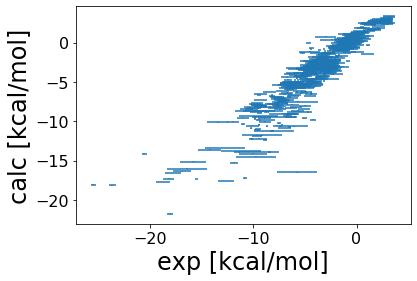

In [7]:
plt.errorbar(exp, calc, yerr=dcalc, xerr=dexp, ls = 'None')
plt.xlabel(f"exp [kcal/mol]")
plt.ylabel(f"calc [kcal/mol]")

now we can compute residuals. the idea is that we want to plot the residuals, extract the molecules with the biggest residuals, and then extract those which have few rotamers...

In [8]:
abs_residuals = abs(np.array(exp) - np.array(calc))

Text(0.5, 0, 'abs residual [kcal/mol]')

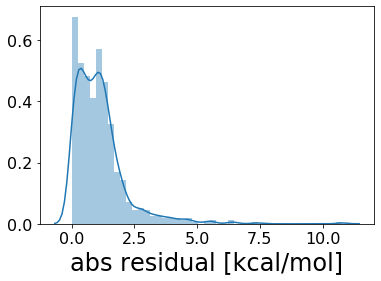

In [9]:
sns.distplot(abs_residuals)
plt.xlabel(f"abs residual [kcal/mol]")

In [10]:
#extract the molecules with abs resid errors greater than 1.5 kcal/mol (arbitrary) and less than 5kcal/mol (arbitrary)
interest_molecules = [(calc_i, exp_i, dcalc_i, dexp_i, smiles_i) 
                      for calc_i, exp_i, dcalc_i, dexp_i, smiles_i in zip(calc, exp, dcalc, dexp, smiles) 
                      if abs(calc_i - exp_i) > 1.4]

In [11]:
#filter of molecule indices that have only CHNO atoms
def has_only_CHNO(oemol):
    """
    return bool if the molecule has only CHNO atoms 
    """
    import openeye as oechem
    acceptable_atomic_numbers = [6, 1, 7, 8]
    atomic_nums = [atom.GetAtomicNum() for atom in oemol.GetAtoms()]
    if set(atomic_nums).issubset(set(acceptable_atomic_numbers)):
        return True
    else:
        return False

def has_le_N_rotatable_bonds(oemol, ceiling):
    """
    return True if the molecule has less than or equal to ceiling rotatable bonds
    """
    import openeye as oechem
    num_rotatables = oechem.OEGetRotatableBondCount(oemol)
    if num_rotatables <= ceiling:
        return True
    else:
        return False

def has_zero_net_charge(oemol):
    """
    return True if the net charge is zero
    """ 
    import openeye as oechem
    net_charge = oechem.OENetCharge(oemol)
    if net_charge == 0:
        return True
    else:
        return False

#OEGetRotatableBondCount
from perses.utils.openeye import smiles_to_oemol
q = smiles_to_oemol('CCCC')
assert has_only_CHNO(q)
assert has_le_N_rotatable_bonds(q, 3)
assert has_zero_net_charge(q)



INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...


In [12]:

filtered_interest_molecules = []
for tup in interest_molecules:
    smiles = tup[-1]
    oem = smiles_to_oemol(smiles)
    if has_only_CHNO(oem) and has_le_N_rotatable_bonds(oem, 2) and has_zero_net_charge(oem) and tup[2] < 0.1 and tup[3] < 0.7:
        filtered_interest_molecules.append(tup)

INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generating now...
INFO:utils.openeye:molecule                       does not have unique atom names. Generati

In [13]:
filtered_interest_molecules

[(-3.23, -4.72, 0.03, 0.6, ' CCCCO'),
 (-5.44, -3.82, 0.03, 0.6, ' c1ccc(cc1)OC=O'),
 (-2.87, -4.84, 0.03, 0.6, ' Cc1cc(cnc1)C'),
 (-3.34, -4.93, 0.03, 0.6, ' Cc1ccncc1'),
 (-3.49, -5.1, 0.02, 0.6, ' CO'),
 (-4.9, -3.15, 0.02, 0.1, ' c1ccc2c(c1)Oc3ccccc3O2'),
 (-8.16, -5.88, 0.03, 0.6, ' Cc1c[nH]c2c1cccc2'),
 (-5.28, -6.79, 0.03, 0.6, ' c1ccc(cc1)CCO'),
 (-14.15, -20.52, 0.08, 0.27, ' C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O'),
 (-3.15, -4.62, 0.03, 0.6, ' CC[C@H](C)O'),
 (-2.08, -4.02, 0.02, 0.6, ' C[N+](=O)[O-]'),
 (-8.28, -10.0, 0.02, 0.6, ' CC(=O)NC'),
 (-3.04, -4.61, 0.03, 0.6, ' CC(=O)C1CC1'),
 (-8.39, -10.17, 0.03, 0.6, ' c1cc(ccc1C#N)O'),
 (-3.39, -5.0, 0.02, 0.6, ' CCO'),
 (-3.2, -5.22, 0.03, 0.6, ' Cc1ccncc1C'),
 (-15.25, -11.85, 0.04, 0.35, ' c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N'),
 (-6.79, -4.52, 0.04, 0.6, ' c1cc2ccc3cccc4c3c2c(c1)cc4'),
 (-8.08, -9.76, 0.04, 0.2, ' Cc1ccc(cc1)C(=O)N(C)C'),
 (-7.74, -9.65, 0.03, 0.6, ' c1cc(cc(c1)O)C#N'),
 (-7.83, -9.8, 0.03, 0.6, ' CC(=O)N1CCC

Text(0.5, 1.0, 'freesolv dataset for MM-->ANI calculations')

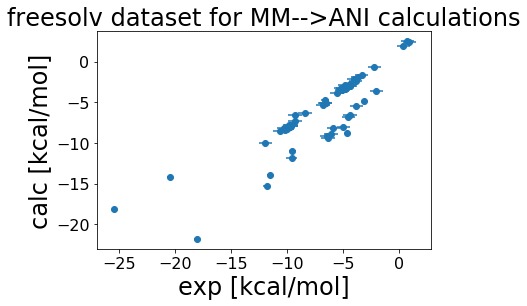

In [14]:
calc = [i[0] for i in filtered_interest_molecules]
exp = [i[1] for i in filtered_interest_molecules]
dcalc = [i[2] for i in filtered_interest_molecules]
dexp = [i[3] for i in filtered_interest_molecules]
plt.errorbar(exp, calc, xerr=dexp, yerr=dcalc, ls = 'None', marker = 'o')
plt.xlabel(f"exp [kcal/mol]")
plt.ylabel(f"calc [kcal/mol]")
plt.title(f"freesolv dataset for MM-->ANI calculations")


In [15]:
np.save(f"freesolv_dataset.npy", filtered_interest_molecules)

In [16]:
from openeye import oedepict
from openeye import oechem
smiles = [i[-1] for i in filtered_interest_molecules]

image = oedepict.OEImage(1000, 1000)

rows, cols = 8,8
grid = oedepict.OEImageGrid(image, rows, cols)

opts = oedepict.OE2DMolDisplayOptions(grid.GetCellWidth(), grid.GetCellHeight(),
                                       oedepict.OEScale_AutoScale)

for smi, cell in zip(smiles, grid.GetCells()):
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, smi)
    oedepict.OEPrepareDepiction(mol)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    oedepict.OERenderMolecule(cell, disp)

oedepict.OEWriteImage("ImageGridSimple.png", image)

True

## Summary:
I have:
- plotted the calculated and experimental hydration free energies from the freesolv dataset
- extracted molecule for which 
    - residuals show >1.4kcal/mol deviation from experimental data
    - contain _only_ C,H,N, and O atoms
    - have experimental errors < 0.7kcal/mol
    - have calculated errors of < 0.1kcal/mol
    - have no more than 2 rotatable bonds
    - have 0 net charge
- plotted the resultant correlation data
- rendered the images of the 64 molecules of interest
- saved the data of the molecules